# Credit Card Default Prediction

This project focuses on understanding the factors that contribute to credit card payment defaults and building a predictive model to identify customers who are at risk. By exploring the dataset, preparing the features, and testing different machine learning algorithms, the project aims to create a practical baseline solution for default prediction.

The goal is not only to build an accurate model, but also to walk through the full workflow: data exploration, preprocessing, model training, evaluation, and interpretation of results. This helps develop a clear understanding of how real-world credit risk prediction problems are approached in machine learning.



In [18]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [19]:
# import dataset
df = pd.read_csv("UCI_Credit_Card.csv")
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (30000, 25)
Columns: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')


## Data Cleaning and preprocessing
In this section we will check for any missing values in the dataset and prepare our data for EDA and Feature engineering

In [20]:
# Missing values 
df.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [21]:
print(df.dtypes)

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object


In [22]:
# Sanity checks

print(df["ID"].is_monotonic_increasing)         # should return True

# check for any unexpected values
cols = ["MARRIAGE", "EDUCATION", "SEX", "default.payment.next.month"]
for col in cols:
    print(f"{col} unique values - {df[col].nunique()} - {df[col].unique()}")

# duplicacy check
print(f"Number of duplicates: {df["ID"].duplicated().sum()}")

print(df.describe().T)        # Look for value ranges/errors

True
MARRIAGE unique values - 4 - [1 2 3 0]
EDUCATION unique values - 7 - [2 1 3 5 4 6 0]
SEX unique values - 2 - [2 1]
default.payment.next.month unique values - 2 - [1 0]
Number of duplicates: 0
                              count           mean            std       min  \
ID                          30000.0   15000.500000    8660.398374       1.0   
LIMIT_BAL                   30000.0  167484.322667  129747.661567   10000.0   
SEX                         30000.0       1.603733       0.489129       1.0   
EDUCATION                   30000.0       1.853133       0.790349       0.0   
MARRIAGE                    30000.0       1.551867       0.521970       0.0   
AGE                         30000.0      35.485500       9.217904      21.0   
PAY_0                       30000.0      -0.016700       1.123802      -2.0   
PAY_2                       30000.0      -0.133767       1.197186      -2.0   
PAY_3                       30000.0      -0.166200       1.196868      -2.0   
PAY_4        

From the dataset description, we come across a few nuisances in the data:

- **Education**: 
  - (1 = graduate school, 2 = university, 3 = high school, 4 = others, 5 = unknown, 6 = unknown)  
  - We will map 0, 5, 6 → 0 (0 represents unknown)

- **Marriage**: 
  - (1 = married, 2 = single, 3 = others)  
  - 0 can be referred to as unknown

- **PAY_x columns**: 
  - (-2, -1 = pay duly/early; 1 = payment delay for 1 month, 2 = payment delay for 2 months, …, 8 = payment delay for 8 months, 9 = payment delay for 9 months or more)  
  - We will map -2 and -1 → 0 (no payment delay)


In [23]:
# mapping
df["EDUCATION"] = df["EDUCATION"].replace({0:0, 5:0, 6:0})

df["MARRIAGE"] = df["MARRIAGE"].replace({0:0})

cols = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
for col in cols:
    df[col] = df[col].replace({-1:0, -2:0})

In [24]:
df = df.rename(columns={"default.payment.next.month": "DEFAULT"})

Now the data is ready for Exploratory Data Analysis. (EDA)

## Exploratory Data Analysis

We will look into the distribution and relationships between features and the target variables. Learnings from Our EDA can be directly applied to make features during feature engineering.

In [25]:
# we will check for class imbalance
df["DEFAULT"].value_counts(normalize=True)

DEFAULT
0    0.7788
1    0.2212
Name: proportion, dtype: float64

As expected, our default and non-default classes are highly imbalanced, which can lead to misleading results for our classifier.  
This issue will be handled carefully during modeling using **SMOTE** or **class weights**.

#### Default Rate Among Different Groups

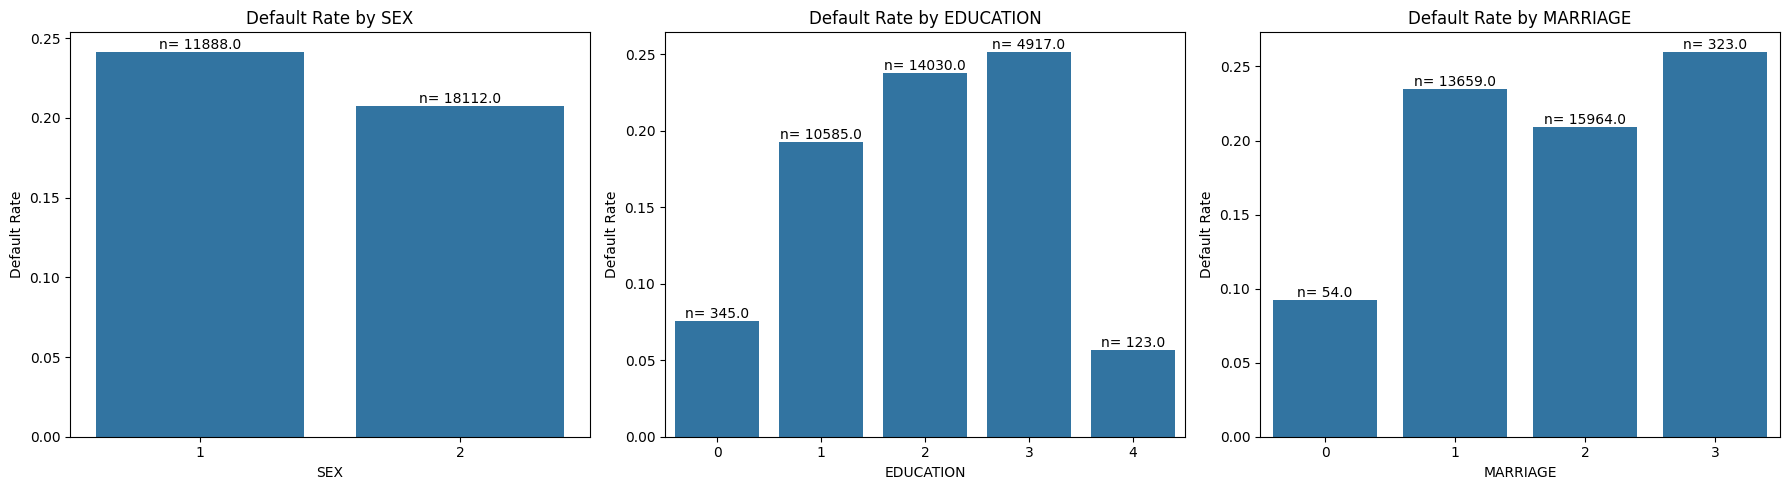

In [41]:
categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]

plt.figure(figsize=(18,5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, len(categorical_features), i)
    
    # create default rate, count for each group
    grouped = df.groupby(feature)["DEFAULT"].agg(["mean", "count"]).reset_index()
    grouped.rename(columns={"mean": "default_rate"}, inplace=True)

    # plot on barplot
    ax = sns.barplot(data=grouped, x=feature, y="default_rate")

    # add counts above bars
    for idx, row in grouped.iterrows():
        ax.text(idx, row["default_rate"], f"n= {row["count"]}", ha="center", va="bottom", fontsize=10, color="black")

    plt.title(f'Default Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Default Rate') 

plt.tight_layout()
plt.show()

**Default Rate by Categorical Features**

We examined default rates across several demographic variables (SEX, EDUCATION, MARRIAGE) and included sample counts for each category to avoid misinterpreting small groups.
- **SEX**: Balanced sample sizes → default rates are reliable.
- **EDUCATION**: Categories 1, 2, and 3 have large sample sizes and show meaningful differences. Categories 0 and 4 are very small, so their rates should not be overinterpreted.
- **MARRIAGE**: Categories 1 and 2 are reliable; category 3 is small, and category 0 is too small to provide stable insights.

Including sample counts helped ensure that conclusions were based on statistically stable groups, avoiding misleading insights from tiny categories.

#### Default rate among different age groups

In [30]:
# assign 5 equal sized age bins
df["age_bins"] = pd.qcut(df["AGE"], 5, duplicates="drop")

# Agg on mean and count to see statiscal significance
default_by_age = df.groupby("age_bins", observed=False)["DEFAULT"].agg(["mean", "count"]).reset_index()
default_by_age.rename(columns={"mean": "default_rate"}, inplace=True)
default_by_age

,age_bins,default_rate,count
0,"(20.999, 27.0]",0.241975,6604
1,"(27.0, 31.0]",0.195876,5626
2,"(31.0, 37.0]",0.205113,6728
3,"(37.0, 43.0]",0.217563,5056
4,"(43.0, 79.0]",0.243234,5986


In [32]:
# compute confidence intervals for each Age bin "wilson method"
from statsmodels.stats.proportion import proportion_confint

ci_low = []
ci_high = []
for _ , row in default_by_age.iterrows():
    p = row["default_rate"]
    n = row["count"]
    low, high = proportion_confint(count=p*n, nobs=n, method="wilson")
    ci_low.append(low)
    ci_high.append(high)

default_by_age["ci_low"] = ci_low
default_by_age["ci_high"] = ci_high
default_by_age   

,age_bins,default_rate,count,ci_low,ci_high
0,"(20.999, 27.0]",0.241975,6604,0.231797,0.252452
1,"(27.0, 31.0]",0.195876,5626,0.185715,0.206453
2,"(31.0, 37.0]",0.205113,6728,0.195634,0.214928
3,"(37.0, 43.0]",0.217563,5056,0.206407,0.229148
4,"(43.0, 79.0]",0.243234,5986,0.232533,0.254265


#### Correlation for default rate and payment habits

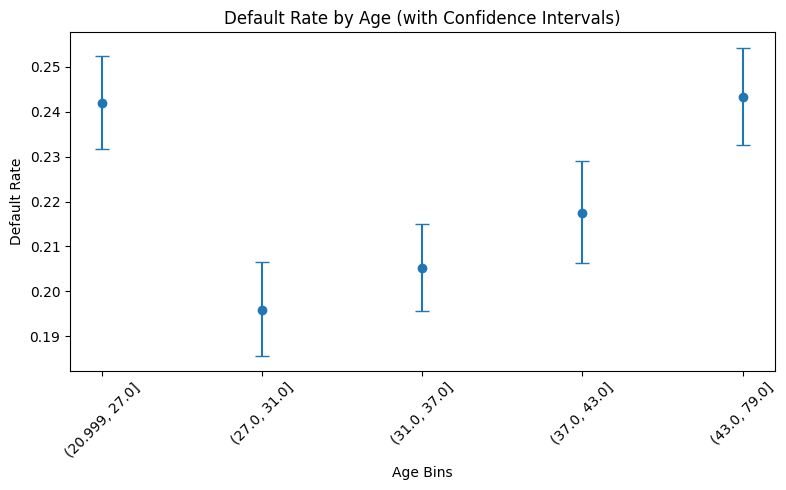

In [35]:
# Plot error bars for visualization
plt.figure(figsize=(8,5))
plt.errorbar(x = default_by_age["age_bins"].astype(str),
             y = default_by_age["default_rate"],
             yerr= [default_by_age["default_rate"] - default_by_age["ci_low"], default_by_age["ci_high"] - default_by_age["default_rate"]], 
             fmt="o", capsize=5
             )
plt.title("Default Rate by Age (with Confidence Intervals)")
plt.xlabel("Age Bins")
plt.ylabel("Default Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Default Rate by Age Group**

To analyze how age affects default likelihood, I binned customers into 5 age groups using quantile-based binning (ensuring each group had similar sample sizes). I then calculated the default rate for each bin. Calculated CI for category size imbalance

I found a U-shaped pattern:
- Youngest and oldest age groups show higher default rates
- Middle-aged customers (27–37) show the lowest default rate

This suggests that age has a non-linear relationship with credit risk.

In [28]:
cols = ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df["average_payment"] = df[cols].apply(lambda row: row.mean(), axis=1)
corr, p_value = pearsonr(df['average_payment'], df['DEFAULT'])
print("Correlation:", corr)
print("p-value:", p_value)

Correlation: 0.37603366963461105
p-value: 0.0



- `average_payment` (mean of PAY_0–PAY_6) correlates positively with default (r ≈ 0.38, p ≈ 0).  
- Interpretation: Customers who generally pay later are more likely to default.  
- Conclusion: `average_payment` is a meaningful predictive feature.

#### Correlation in default and credit limit

In [29]:
corr, p_value = pearsonr(df["LIMIT_BAL"], df["DEFAULT"])
print("Correlation:", corr)
print("p-value:", p_value)

Correlation: -0.15351987639350817
p-value: 1.3022439532535352e-157


#### Distribution checks
We will plot some key distributions to analize any insane outliers and skew.

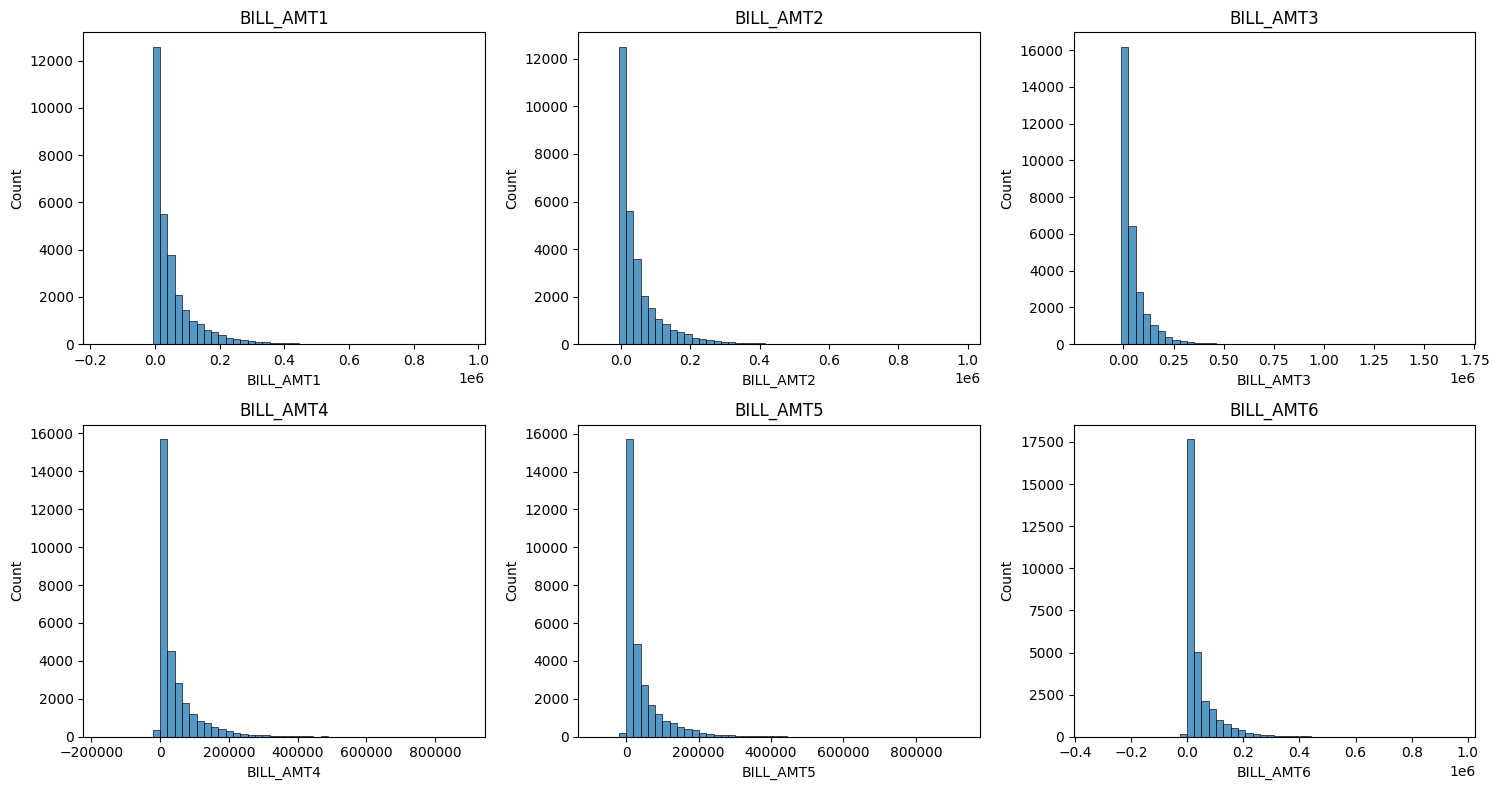

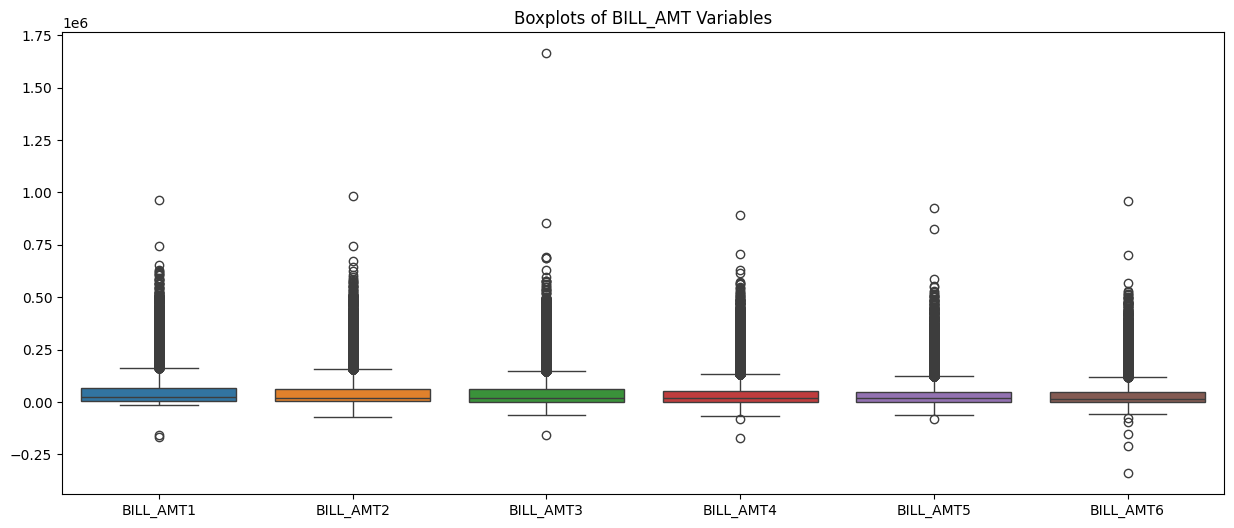

In [ ]:
cols_bill = ["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]

plt.figure(figsize=(15,8))
for i, col in enumerate(cols_bill, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=50, kde=False)
    plt.title(col)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15,6))
sns.boxplot(data=df[cols_bill])
plt.title("Boxplots of BILL_AMT Variables")
plt.show()


All six historical bill amounts are heavily right-skewed with long positive tails, which is expected in financial data. A small number of customers carry very large balances, while most carry lower balances.
Boxplots confirm the presence of many high outliers.

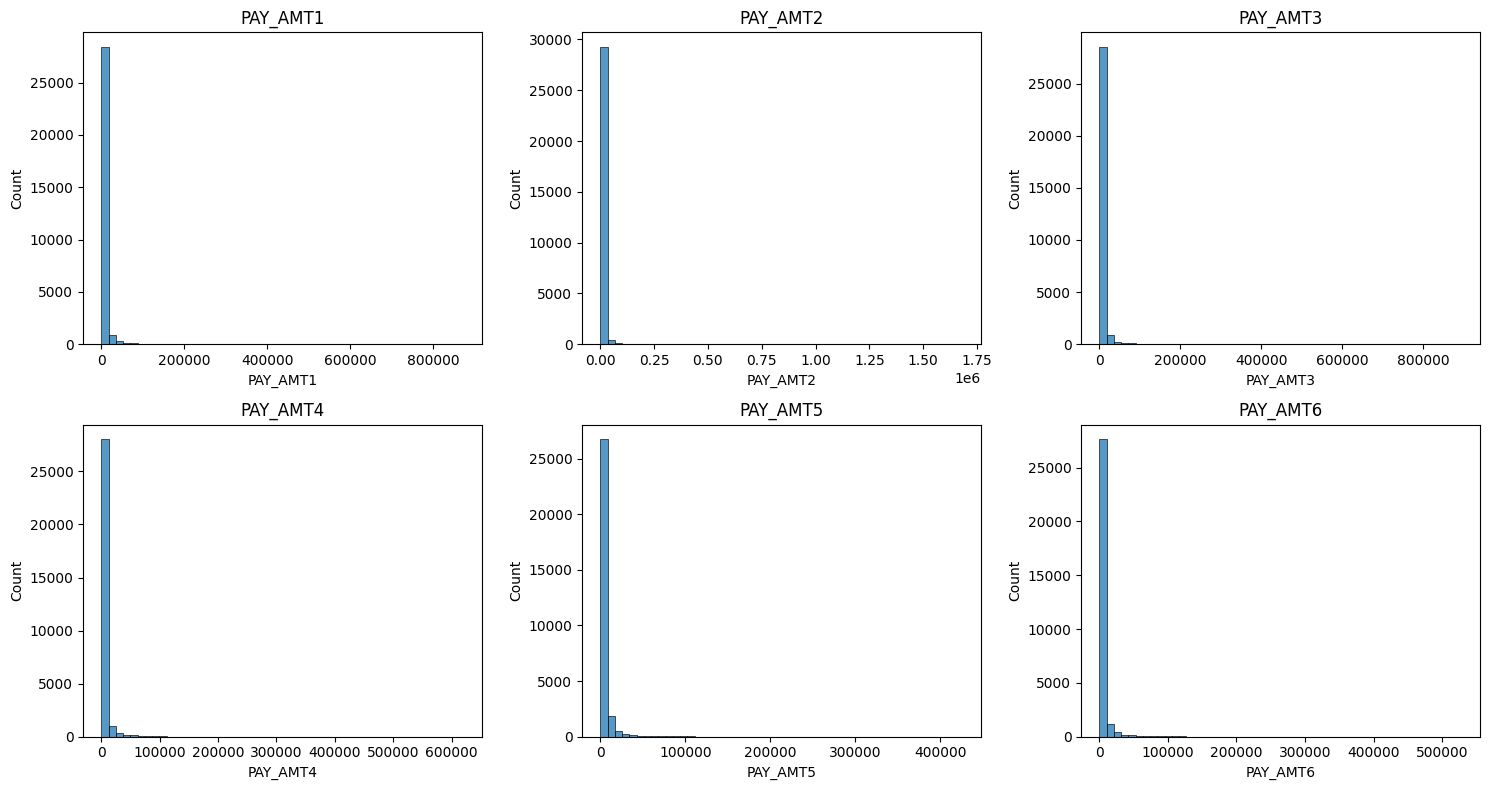

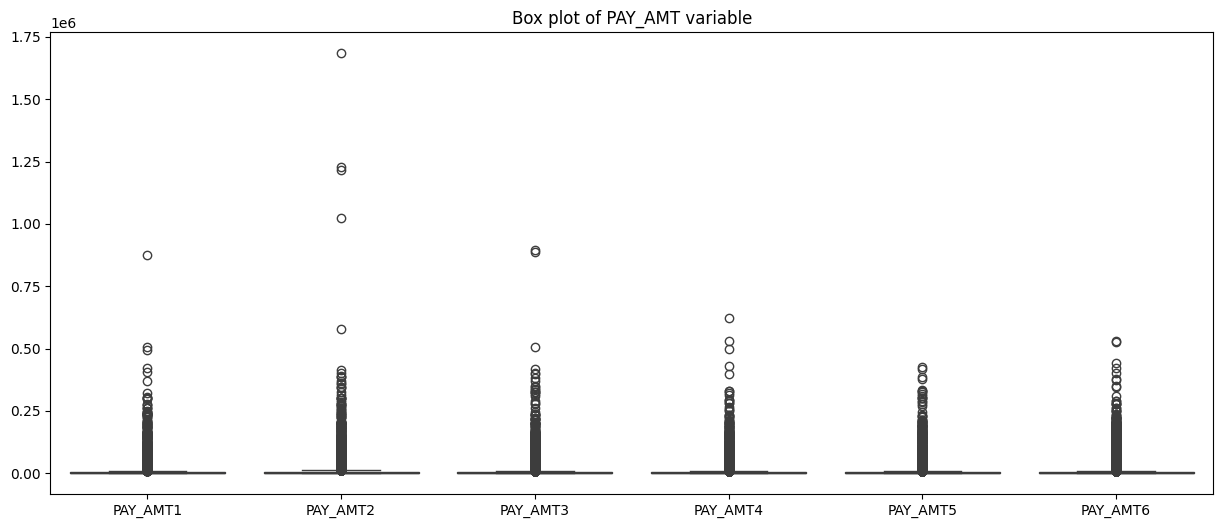

In [45]:
cols_pay = ['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

plt.figure(figsize=(15,8))
for i, col in enumerate(cols_pay, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], bins=50, kde=False)
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,6))
sns.boxplot(data = df[cols_pay])
plt.title("Box plot of PAY_AMT variable")
plt.show()

The PAY_AMT variables are heavily zero-inflated and extremely right-skewed. Most customers make very small or zero payments, while a tiny number of customers make exceptionally large payments. Because of this, traditional histograms and boxplots are not very informative; the signal collapses near zero with only a few extreme outliers determining the visible range.

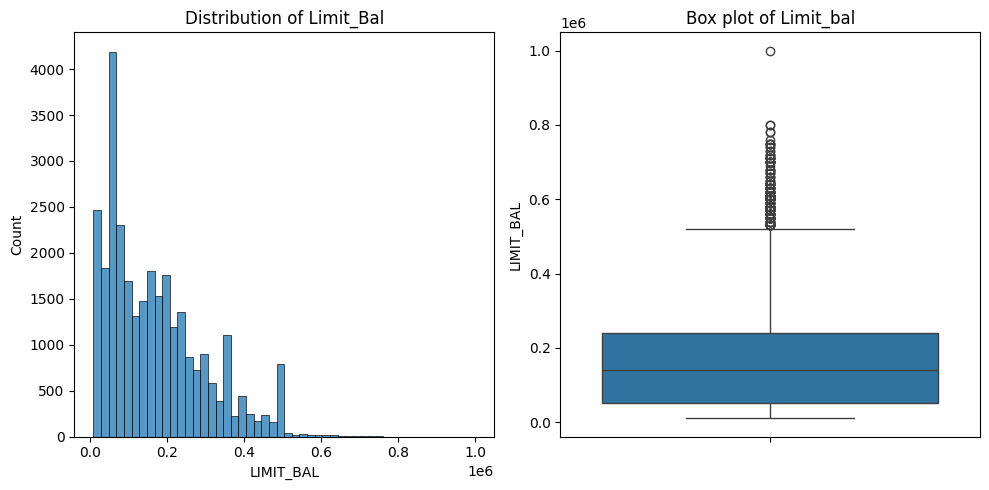

In [54]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df["LIMIT_BAL"], bins=50, kde=False)
plt.title("Distribution of Limit_Bal")
plt.subplot(1,2,2)
sns.boxplot(data=df["LIMIT_BAL"])
plt.title("Box plot of Limit_bal")
plt.tight_layout()
plt.show()


The credit limit variable is heavily right-skewed, which is typical of financial datasets. Most customers have relatively low credit limits (between 10,000 and 200,000), while a smaller number have significantly higher limits. A very small set of customers have limits close to 1,000,000, which appear as outliers in the boxplot.

The outliers likely represent high-income customers and are not data errors. These values will be relevant during feature engineering: tree-based models can naturally handle the wide range, while linear models may require scaling or transformations to reduce the influence of extreme values.

In [55]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT',
       'age_bins', 'average_payment', 'num_zero_payments'],
      dtype='object')

,PAY_6,DEFAULT
PAY_6,1.000000,0.244437
DEFAULT,0.244437,1.000000
